# Environmental Impact of Agricultural Practices in the World

**ADA Project Milestone 2**

This notebook consists of our initial Data Analysis of the FAOSTAT dataset on Food an agriculture. We will first study the contents of the data and its strucuture, before restructuring it in order to start our analysis. Also, some research questions initially asked will be answered by the end of this notebook.

## A. Initial Analysis

The dataset initially contained 78 csv files, but some of them were discarded as they will not be useful for our analysis. We have selected 20 CSVs that would help us with our analysis.

In [1]:
from glob import glob
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
csv_files = [x for x in glob('data/**/*.csv') if 'item_groups' not in x and 'population' not in x]
len(csv_files)

19

We split those 20 (but we omitted the population for now) csv into different directories, one for each group of csv. Each group corresponds to one category:
```.
+-- data/
|   +-- emissions_agriculture/
|      +-- ...
|   +-- emissions_land/
|      +-- ...
|   +-- environment/
|      +-- ...
|   +-- inputs/
|      +-- ...
|   +-- population/
|      +-- ...
|   +-- production/
|      +-- ...
```

---
### A.1 Schema consistency
---

We will first study the schemas of all the csv files we have in order to see if they are consistent or require changes

#### 1. Checking column names across whole dataset
---

Now, let's scan all the csv files and check their schemas.

In [3]:
from scanning import scan_columns

all_columns = scan_columns(csv_files)

print("The found columns, grouped, are:\n")
for cols, f in all_columns:
    print(list(sorted(cols)), f"Num files {len(f)}")

The found columns, grouped, are:

['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year', 'yearcode'] Num files 13
['country', 'countrycode', 'element', 'elementcode', 'elementgroup', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'] Num files 1
['area', 'areacode', 'element', 'elementcode', 'flag', 'months', 'monthscode', 'unit', 'value', 'year', 'yearcode'] Num files 1
['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'note', 'unit', 'value', 'year', 'yearcode'] Num files 3
['country', 'countrycode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year', 'yearcode'] Num files 1


As we can see, sometimes the columns `area` and `areacode` are named `country` and `countrycode`, only because some csv files only contain country data, without country groups. We will rename those as to have a unified schema. Also, some files have the `note`, `elementgroup` and `months` columns. We will look into those in subsequent steps as we are now simply checking whether column naming is consistent.

In order to obtain a more consistent column naming, we will rename `country` to `area` and `countrycode` to `areacode`.

In [4]:
column_rename = {'country': 'area', 'countrycode': 'areacode'}

In [5]:
all_columns_2 = scan_columns(csv_files, column_rename)
print(f"After renaming, we obtain the following columns:\n")
for cols, f in all_columns_2:
    print(list(sorted(cols)), f"Num files {len(f)}")

After renaming, we obtain the following columns:

['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year', 'yearcode'] Num files 14
['area', 'areacode', 'element', 'elementcode', 'elementgroup', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'] Num files 1
['area', 'areacode', 'element', 'elementcode', 'flag', 'months', 'monthscode', 'unit', 'value', 'year', 'yearcode'] Num files 1
['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'note', 'unit', 'value', 'year', 'yearcode'] Num files 3


#### 2. Checking which columns to drop
---

##### 1. Column labeled "`note`"

Now we have a few files that have different schemas. One column that we should look into before continuing is `note`, as it is in 4 files.

In [6]:
from data_processing import load_dataframe
from utils import get_column_unique_values

files_with_note = all_columns_2[-1][1]
for f in files_with_note:
    d = load_dataframe(f, column_rename)
    note_values = get_column_unique_values(d, ['note'])
    print(f"Values for \"note\" in {f} are {note_values.values}")

Values for "note" in data/emissions_agriculture/Emissions_Agriculture_Burning_crop_residues_E_All_Data_(Normalized).csv are [[nan]]
Values for "note" in data/emissions_agriculture/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).csv are [[nan]]
Values for "note" in data/emissions_agriculture/Emissions_Agriculture_Synthetic_Fertilizers_E_All_Data_(Normalized).csv are [[nan]]


As we can see, all values for this column are NaN, so we can safely drop the column.

2. Columns "`yearcode`" and "`elementgroup`"

We figured it would be useful to scan for duplicate columns in each dataframe (i.e. columns with different names but same values)

In [7]:
from scanning import scan_column_duplicates
duplicates = scan_column_duplicates(csv_files, column_rename)
for c, f in duplicates:
    print(f"Duplicates for {c} in {len(f)} files")

Duplicates for [('yearcode', 'year')] in 18 files
Duplicates for [('elementgroup', 'elementcode')] in 1 files


As we can see, most files have `year` and `yearcode` columns which are equal, as well as for `elementgroup` and `elementcode`. Hence, we can safely drop `yearcode` and `elementcode` column. 

Hence, we can define a list of columns to be checked and dropped if they are duplicate of others, and drop all columns who are all `NaN`

In [8]:
duplicate_cols = ["yearcode", "elementgroup"]
all_columns_3 = scan_columns(csv_files, column_rename, duplicate_cols)
print(f"After renaming and dropping columns, we obtain the following columns:\n")
for cols, f in all_columns_3:
    print(list(sorted(cols)), f"Num files {len(f)}")

After renaming and dropping columns, we obtain the following columns:

['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'] Num files 15
['area', 'areacode', 'element', 'elementcode', 'flag', 'months', 'monthscode', 'unit', 'value', 'year'] Num files 1
['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'note', 'unit', 'value', 'year'] Num files 3


We now have 15 files with identical schemas, and 2 files that have a different one:
 - The file containing the `elementgroup` additional column, which refers to groups of `elements`
 - The file with monthly data and no `item` and `itemcode` columns
 
To obtain the desired format, we can now call `load_clean_dataframe(<file>, column_rename, duplicate_cols)` with `column_rename = {'country': 'area', 'countrycode': 'areacode'}` and `drop_columns = ["note", "yearcode", "elementgroup"]`

The only remaining csv with different schema are:
- `data/environment/Environment_Temperature_change_E_All_Data_(Normalized).csv` (which contains monthly data)
- `data/environment/Environment_Energy_E_All_Data.csv`, which contains `elementgroup` column

---
### A.2 Schema description

---
Now that we have a unified schema for (almost) all csv files, we can start looking into the meaning of each column and their possible value. 

- `area` and `areacode` : These two fields describe where the measurement was done. Usually, each the relationship should be one-to-one. FAO provides us with a csv file containing the unique one-to-one (two way) mapping, so we can discard the column `area` and only work with `areacodes`
- `elementcode`, `element` and `unit`: And element code uniquely identifies an element (i.e. a measure like Production) and a unit (tonnes, heads ...) pair. Since we don't have a mapping provided by FAO, we will construct one with the data. We expect to have a one-to-one mapping between elementcode <-> (element, unit)
-  `flag`: There are flags set by the FAO that describe how the data was obtained, for each datapoint. We have decided to drop this column as it is not useful for our analysis.
- `item` and `itemcode`: Again, we expect a one-to-one mapping between those two. They represent the category on which the measurement (i.e. (element, unit)) was done. It can be for example "Cattle", "Chickens", etc ... The mapping will be constructed from the available data.
- `value`: This is the actual value of the measure quantity.

#### 1. Area columns
---
As said previously, the `area` column will be dropped, but we still need the mapping. 

In [9]:
from data_processing import load_dataframe
from mappings import get_mapping, is_unique_mapping
area_codes = load_dataframe('data/countries.csv')
area_codes.head()

,countrycode,country,m49code,iso2code,iso3code,startyear,endyear
0,2,Afghanistan,4.0,AF,AFG,NaN,NaN
1,5100,Africa,2.0,NaN,X06,NaN,NaN
2,284,Ã land Islands,248.0,NaN,ALA,NaN,NaN
3,3,Albania,8.0,AL,ALB,NaN,NaN
4,4,Algeria,12.0,DZ,DZA,NaN,NaN


Another important aspect regarding those columns. If we look at the second line of the printed dataframe, we can see "Africa". FAO provides also another csv that contains country groups, where they describe which country is in which group. This can be useful as to conduct a broader anaylsis.

In [10]:
country_groups = load_dataframe('data/country_groups.csv')
country_groups.head()

,countrygroupcode,countrygroup,countrycode,country,m49code,iso2code,iso3code
0,5100,Africa,4,Algeria,12.0,DZ,DZA
1,5100,Africa,7,Angola,24.0,AO,AGO
2,5100,Africa,53,Benin,204.0,BJ,BEN
3,5100,Africa,20,Botswana,72.0,BW,BWA
4,5100,Africa,24,British Indian Ocean Territory,86.0,IO,IOT


Here, countries are grouped into multiple `countrygroup`, so we know exactly of which countries each group is formed. These country groups are present in the dataset as `area`, meaning there are aggregated values in the dataset. For example: we can find the emissions for "Algeria" and for "Africa", where the latter is an aggregated value over the whole group. We will need to be careful when aggregating values in the future, as we could account multiple times for one country.

In [11]:
is_unique_mapping(area_codes[['country', 'countrycode']].drop_duplicates(), 'country', ['countrycode'])

True

#### 2. Element Columns
---

The `element` and `elementcode` represent the measure quantity for a given `item`. A quantity has a name and a unit, which is why we believe these two columns should also have a one-to-one mapping accross the whole dataset. Also, since an `elementcode` potentially uniquely identifies (`element`, `unit`) pair, we might drop those two columns as to make the csv files smaller and easier to manipulate.

First let's check if indeed this mapping is one-to-one:

In [12]:
from data_processing import get_all_column_unique_values
element_values = get_all_column_unique_values(csv_files, column_rename, duplicate_cols, ['elementcode', 'element', 'unit'])
is_unique_mapping(element_values, 'elementcode', ['element', 'unit'])

True

As we can see, `elementcode` uniquely identify (`element`, `unit`) pairs, so we can safely drop those two columns and only use `elementcode`. We will later pivot each csv as to obtain all the `elementcode`s as columns, so we can reduce de number of rows significantly. A mapping using a dictionnary will of course be necessary in order to have a nice GUI where users can select the (element, unit) pair instead of the code.

#### 3. Item columns
---

According to FAOSTAT, the `item` and `itemcode` columns represent item on which measurements were done. For example an item can be `cattle` and the measurement can be "CH4 emissions in gigagrams". 
Similarly to what we did above, we expect `item` and `itemcode` to have a one-to-one relationship. Let's verify this using the same functions

In [13]:
item_values = get_all_column_unique_values(csv_files, column_rename, duplicate_cols, ['item', 'itemcode'], with_file=True)
is_unique_mapping(item_values[['item', 'itemcode']], 'item', ['itemcode'])

False

It seems that `item` to `itemcode` is not unique for a few items, let's check those and try to understand why it is the case.

In [14]:
grpd = item_values.groupby('itemcode')['item'].agg(set)
grpd[grpd.apply(len) > 1]

Series([], Name: item, dtype: object)

The mapping `itemcode` -> `item` is unique, now let's check the other way around

In [15]:
grouped = item_values.groupby('item')['itemcode'].agg(set)
grouped[grouped.apply(len) >1]

item
Cattle                      {866, 1757}
Chickens                   {1057, 1054}
Disinfectants              {1358, 1351}
Mineral Oils               {1354, 1316}
Other Pesticides nes       {1355, 1359}
Plant Growth Regulators    {1356, 1341}
Name: itemcode, dtype: object

**a.** Some items are related to pesticides. Let's in which csv files they appear

In [16]:
pesticide_items = ["Disinfectants", "Mineral Oils", "Other Pesticides nes", "Plant Growth Regulators"]
item_values[item_values.item.isin(pesticide_items)].file.unique()

array(['data/inputs/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv'],
      dtype=object)

Some duplicate items with the same name but different codes appear in only one csv file, which seems quite odd. We suspect having duplicate rows in that case. Let's check that out.

In [17]:
from data_processing import get_duplicate_items
t = load_dataframe('data/inputs/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv', column_rename, duplicate_cols)
get_duplicate_items(t)

,item,itemcode
0,Disinfectants,"[1358, 1351]"
1,Mineral Oils,"[1354, 1316]"
2,Other Pesticides nes,"[1359, 1355]"
3,Plant Growth Regulators,"[1356, 1341]"


We now know that there are potentially duplicate rows for the same `item` but a different `itemcode` (with the same measurements). Hence, we need to add a functionnality that checks for duplicated items in the dataframe.

**b.** Now let's look at livestock items

In [18]:
livestock_items = ["Cattle", "Chickens"]
for i in item_values[item_values.item.isin(livestock_items)].groupby(['item', 'itemcode']).agg(set).reset_index().values:
    print(i)

['Cattle' 866
 {'data/production/Production_Livestock_E_All_Data_(Normalized).csv'}]
['Cattle' 1757
 {'data/emissions_agriculture/Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Normalized).csv', 'data/emissions_agriculture/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Normalized).csv', 'data/emissions_agriculture/Emissions_Agriculture_Manure_Management_E_All_Data_(Normalized).csv', 'data/emissions_agriculture/Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Normalized).csv'}]
['Chickens' 1054
 {'data/emissions_agriculture/Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Normalized).csv', 'data/emissions_agriculture/Emissions_Agriculture_Manure_Management_E_All_Data_(Normalized).csv', 'data/emissions_agriculture/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Normalized).csv'}]
['Chickens' 1057
 {'data/production/Production_Livestock_E_All_Data_(Normalized).csv'}]


The `itemcode` -> `item` seems one-to-one in each csv file, but we see that there are two distinct `itemcode` for "Cattle" and "Chickens" accross all csv files.

It seems that different values for `itemcode` for both "Chickens" and "Cattles" differ when the measured quantity is realted to emissions. Thus, this might be a discrepancy in the data as it does not appear for other items. We will treat this discrepancy once all csv have been merged into one.

---
### A.4 Grouping items into itemgroups

---

Now that we have a good idea on how the data is structured, it would be good to start thinking how we would perform our analysis to answer our research questions.


In [20]:
num_items = item_values[['item', 'itemcode']].drop_duplicates().shape[0]
print(f"There are {num_items} different items in the dataset")

There are 388 different items in the dataset


This number seems quite large, and filtering/choosing the best items for the analysis seems like a tedious task. Luckily, FAO provides us with `itemgroups`, which are simply groups of items. Those are especially important for production, as they group similar products together.

In order to reduce the number of items and reduce the risk of arbitrarily choosing some for the analyis, we will instead work with itemgroups.

From the original dataset, we have produced a new one, aggregating items into itemgroups. However, the code is not included in the notebook as it is not useful.

---
### A.3 Conclusion about Schemas

---

After having applied some analysis on the initially different schemas of the dataframes, we are now able to obtain identitcal schemas all of them but one (which is monthly data).

The common schema has the following columns:

`['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year']`

For now, we have come up with a few steps that should be applied when loading a dataframe:
 - Rename columns to remove spaces and captial letters
 - Rename "Country" to "Area" and "CountryCode" to "Areacode"
 - Drop columns that are either duplicates or NaN values
 - Rename "gigagrams" to "Gigagrams", as otherwise we would have a non one-to-one mapping for `elementcode`
 - Check for items if they have duplicate rows.

The function that does all of steps is `data_processing/load_clean_dataframe`.

Also, we have decided to only work with codes (i.e. `areacode` and `elementcode`) and drop `area`, `element` and `unit`. Of course, we will need a mapping from `code` -> `value`. Additionally, in order to keep track of `countrygroup` and do know how values are aggregated, we will also create a mapping that tells us which countries form a group, by codes.

Hence, to load a dataframe, we simply call :
```
df = load_clean_dataframe(<filename>, column_rename, check_columns, drop_columns)
```

with  `column_rename = {'country': 'area', 'countrycode': 'areacode'}` and `check_columns = ["note", "yearcode", "elementgroup"]` and `drop_columns = ["area", "item", "element", "unit"]`

In [20]:
column_rename = {'country': 'area', 'countrycode': 'areacode'}
duplicate_cols = ["yearcode", "elementgroup"]
csv_files = glob("data_cleaned/**/*.csv")

We have re-oganized the dataset as to obtain only grouped items. this has drastically reduced the number of items we work with:

In [21]:
item_values = get_all_column_unique_values(csv_files, column_rename, duplicate_cols, ['item', 'itemcode'])
element_values = get_all_column_unique_values(csv_files, column_rename, duplicate_cols, ['elementcode', 'element', 'unit'])
is_unique_mapping(item_values[['item', 'itemcode']], 'item', ['itemcode']), item_values[['itemcode', 'item']].drop_duplicates().shape[0]

(True, 96)

The `itemcode`<->`item` mapping is unique, and we have reduced the number of items to 96, which seems much better to work with.


Now we need to get the mappings for :
- `elementcode` -> (`element`, `unit`) (unique in both ways)
- `itemcode` -> `item` (unique in that way, but not the other way around)
- `areacode` -> `area` (unique in both ways)

In [22]:
from mappings import get_mapping, get_area_mapping, get_country_groups
item_mapping = get_mapping(item_values,['itemcode','item'])
element_mapping = get_mapping(element_values, ['elementcode', 'element', 'unit'])


In [23]:
area_mapping = get_area_mapping("data/countries.csv")
country_groups = get_country_groups("data/country_groups.csv")

---
---
---
## B. Diving into the data

Now that the data is in an appropriate format, we can start our analysis and start following our research Path.

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette(sns.color_palette("muted"))
sns.set_style("darkgrid")

---
### 1. What is the overall impact of the agriculture industry on global green house gas (GHG) emissions ?
---

This first question that naturally comes to mind. FAO provides data regarding emissions from multiple sectors. Green house gase emissions are computed using `CO2eq` (i.e. CO2 equivalent) from multiple gases (CO2, CH4, N20, and F-gases), which are in top list of Green House Gases.

In [121]:
emissions_df = load_dataframe("data_cleaned/environment/Environment_Emissions_by_Sector.csv").drop("unnamed:0", axis=1)

Let's first see the share of each sector as a timeline, for the whole world

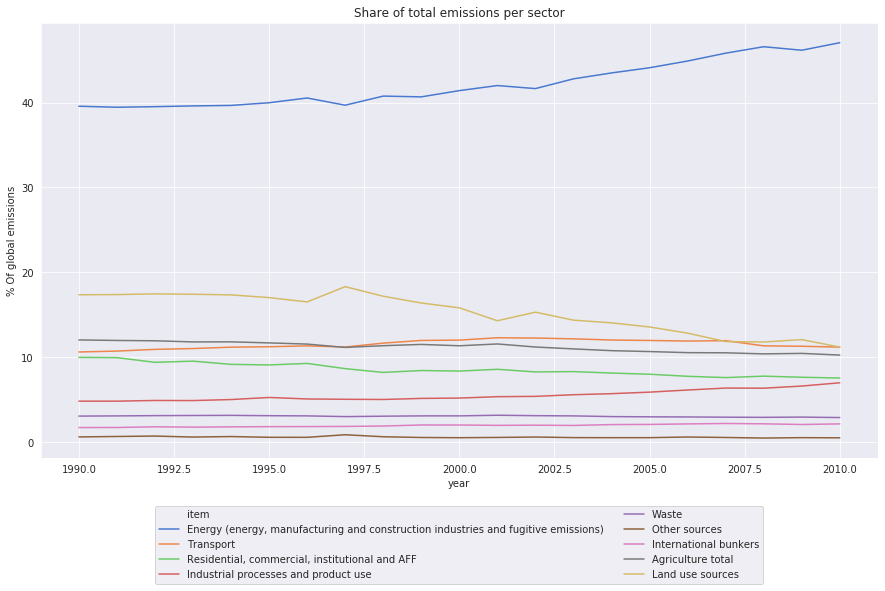

In [122]:
fig, ax = plt.subplots(figsize=(15, 8)) 
emission_shares_world = emissions_df[(emissions_df.elementcode == 7263) & (emissions_df.areacode == 5000)]
g = sns.lineplot(x='year', y='value', data=emission_shares_world, hue='item', ax=ax)
g.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=2);
ax.set_title("Share of total emissions per sector")
ax.set_ylabel("% Of global emissions");

It seems that agriculture has stayed around 10% of global emissions by sector for the years 1990-2010. Now we shall look at the share of this emissions for each gas, only looking at the World wide Agriculture emissions.

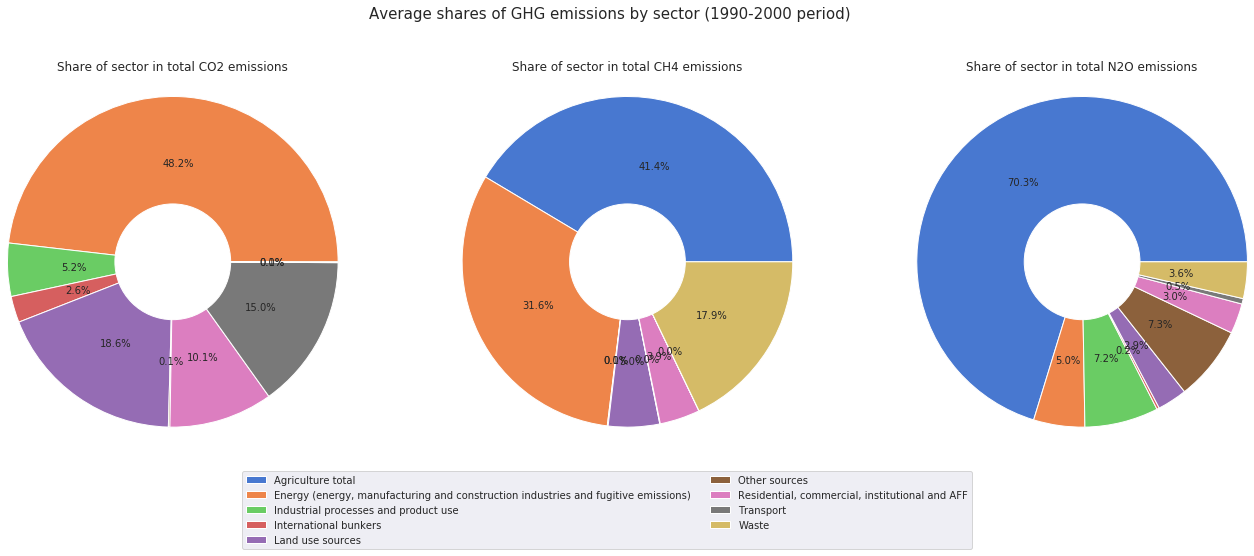

In [123]:
from plotting import plot_pie
emission_ghg_shares = emissions_df[emissions_df.elementcode.isin([7264, 7265, 7266]) & (emissions_df.areacode == 5000)]
fig, axs = plt.subplots(figsize=(20, 20), ncols=3)
for i, code in enumerate(emission_ghg_shares.elementcode.unique()):
    ax = axs[i]
    df = emission_ghg_shares[emission_ghg_shares.elementcode == code].groupby(['area', 'item'])['value'].mean().reset_index()
    labels, vals = df.item.values, df.value.values
    title = f"{element_mapping[code][0]}"
    plot_pie(vals, labels, ax, title)
plt.subplots_adjust(wspace = 1.2)
plt.legend(labels, loc='center', bbox_to_anchor=(-1.8, -0.7), ncol=2);
fig.suptitle("Average shares of GHG emissions by sector (1990-2000 period)", x=0.5, y=0.68, size=15);


From this pie chart, we can learn a few things for the Agriculture industry:
 - It seems that direct CO2 emissions from Agriculture are absent (0%). This makes sense as C02 is not directly emitted. However, the CO2 emissions might be indirect, as food is always transported via non carbon-free methods, and industrial machinery is used in agriculture, and requires energy.
 - Global CH4 Emissions are shared between Agriculture and Energy industries, with a majority for Agriculture (41.4%)
 - Global N2O are largely dominated by the Agriculture industry (70%)

All of these gases are considered top level Green House gases. It makes sense now to focus on searching where those emissions come from in detail (only for agriculture), and how can we reduce them without comprimising the diet of the population.

Now we know which GHG are largely emitted by the agriculture industry, and that Agriculture contributes to roughly 10% of global Emissions, but largely dominates other sectors in terms of CH4 and N2O emissions. 

However, this plot does not take into consideration indirect emissions due to Agriculture:
- Emissions due to transport of food (included in "Transport" sector)
- Emissions due to use of energy for producing agricultural products (included in "Energy")

Our analysis focuses more on the direct emissions of Agriculture, and hence we will not take those aspects in consideration as they fall outside of the scope.

---
### 2. What are the sources of CH4 and N2O emissions from in the Agriculture Industry ?
---

To illustrate this, we can separate the emissions of both gases into 10 items related to agriculture: Enteric Fermentation, Manure management, Rice Cultivation, Synthetic Fertilizers, Manure applied to soils, Manure left on Pasture, Crop residues, Burning of crop residues, Burning of savanna and Cultivation of organic Soils.


In [239]:
world_countries = country_groups[5000]
emissions_agriculture = load_dataframe("data_cleaned/emissions_agriculture/Emissions_Agriculture_Agriculture_total.csv").drop("unnamed:0", axis=1)
emissions_agriculture = emissions_agriculture[emissions_agriculture.year < 2020] # Filter predictions

In [240]:
from plotting import add_zero_values
co2_ch4_emissions_codes = [7225, 7230]

# Get elements of interest, and world countries
emissions_agr_ch4_co2_world = emissions_agriculture[emissions_agriculture.elementcode.isin(co2_ch4_emissions_codes) & emissions_agriculture.areacode.isin(world_countries)]
emissions_agr_ch4_co2_world = emissions_agr_ch4_co2_world.groupby(['elementcode', 'element', 'unit', 'item', 'itemcode', 'year'])['value'].sum().reset_index()
# Group by to get world values
emissions_agr_ch4_co2_world_grpd = emissions_agr_ch4_co2_world.groupby(['elementcode', 'element', 'unit', 'item', 'itemcode'])['value'].mean().reset_index()
emissions_agr_ch4_co2_world_grpd = add_zero_values(emissions_agr_ch4_co2_world_grpd, element_mapping, item_mapping)

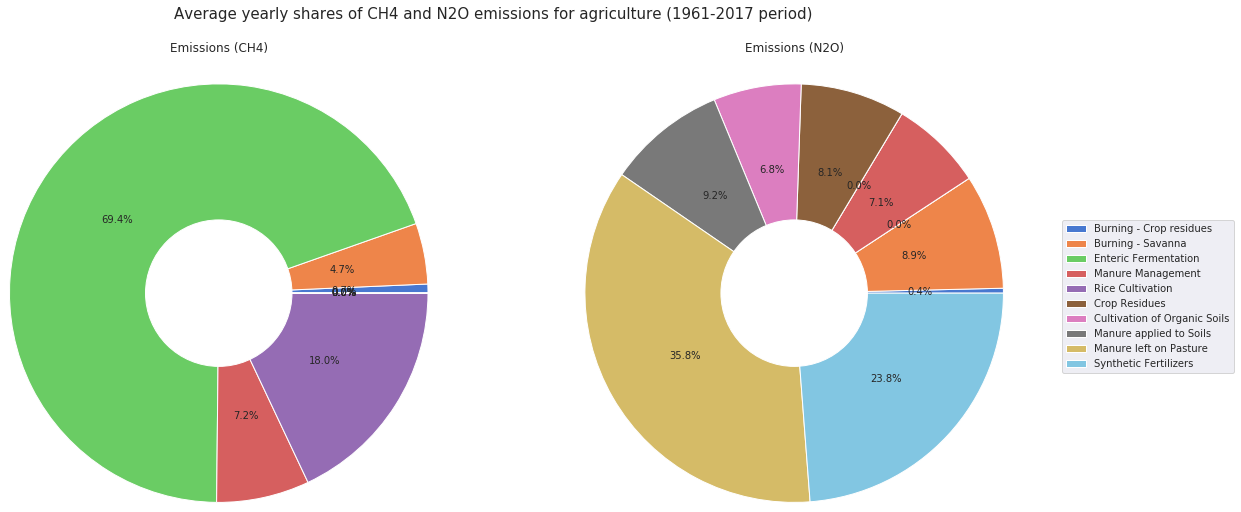

In [241]:
from plotting import plot_pie
fig, axs = plt.subplots(figsize=(15, 10), ncols=2)
for i, code in enumerate(emissions_agr_ch4_co2_world_grpd.elementcode.unique()):
    ax = axs[i]
    df = emissions_agr_ch4_co2_world_grpd[emissions_agr_ch4_co2_world_grpd.elementcode == code]
    labels, vals = df.item.values, df.value.values
    title = f"{element_mapping[code][0]}"
    plot_pie(vals, labels, ax, title)
plt.subplots_adjust(wspace = 1.2)
plt.legend(labels, loc='upper right', bbox_to_anchor=(2.2, 0.8), ncol=1);
fig.suptitle("Average yearly shares of CH4 and N2O emissions for agriculture (1961-2017 period)", x=0.5, y=0.9, size=15);


This pie chart illustrates quite well the origin of emissions of CH4 and N2O, in the agriculture industry. Before interpreting the chart, let's brievly explain what each item represents:
- Burning - Crop residues: Agricultural practice that consists of combusting a percentage of crop residues on site
- Burning - Savanna: Periodic prescribed burning of savanna for agricultural purposes
- Enteric Fermentation: Digestive process by which carbohydrates are broken down by micro organisms into simple molecules for absorption into the bloodstream of an animal.
- Manure Management: Refers to capture, storage, treatment, and utilization of animal manure
- Rice Cultivation: Agricultural practice for growing rice seeds
- Crop Resdiues: Agriculture management practice that consists in returning to managed soils the residual part of the produce
- Cultivation of Organic Soils:
- Manure applied to Soils: Animal waste distributed on fields in amounts that enrich soils
- Manure left on pasture: Animal waste left on managed soils from grazing livestock. 
- Synthetic Fertilizers: Inorganic material of synthetic origin added to a soil to supply one or more plant nutrients essential to the growth of plants.

#### Chart Intepretation:
1. CH4 Emissions:

    - Direct CH4 emissions of agriculture are mostly dominated by the Enteric Fermentation of Livestock (69.4%), which means that this particular source of emissions accounts for rougly 30% of the global CH4 Emissions, which is quite significant.
    - Rice Cultivation also is a big contributor (18%) to the emissions of this GHG.
    - Other sources have much lower contribution to emissions of this gas

2. N2O Emissions:
    - The biggest contributor is "Manure Left on Pasture", follows by Synthetic Fertilizers.
    - The use of Manure (Manure management, left on pasture, and applied to soils) have a contribution of roughly 40% (together) of N2O Emissions for agriculture.

---
### 3. How has the emissions global emissions of those gases from each source evolved in the past years ?
---
Having an average share of each source over the past 50 years gives us a general idea of where the emissions come from. Additionally, the evolution of emissions in this time frame is also interesting.

We all know Global emissions have increased worldwide, but what are the sources of this increase in the agricultural sector ?

#### 1. General evolution of emissions of CH4 and N2O in agriculture

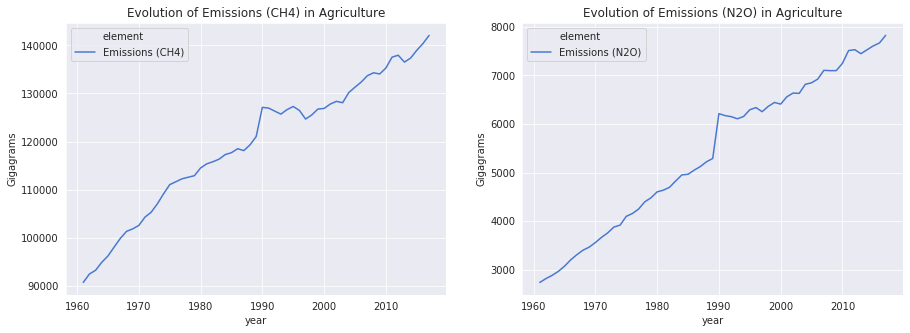

In [242]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=2)
plot_data = emissions_agr_ch4_co2_world.groupby(['elementcode', 'element', 'unit', 'year'])['value'].sum().reset_index()
for i, e in enumerate(plot_data.elementcode.unique()):
    ax = axs[i]
    sns.lineplot(x='year', y='value', data=plot_data[plot_data.elementcode == e], hue='element', ax=ax)
    ax.set_ylabel("Gigagrams")
    ax.set_title(f"Evolution of {element_mapping[e][0]} in Agriculture")

We can notice a clear linear increase in the emission of both gases , with a slight peak in 1990-1995. Now let's look at the decomposition into all the sources we have.

#### 2. Evolution of emissions of CH4 and N2O in agriculture for each source

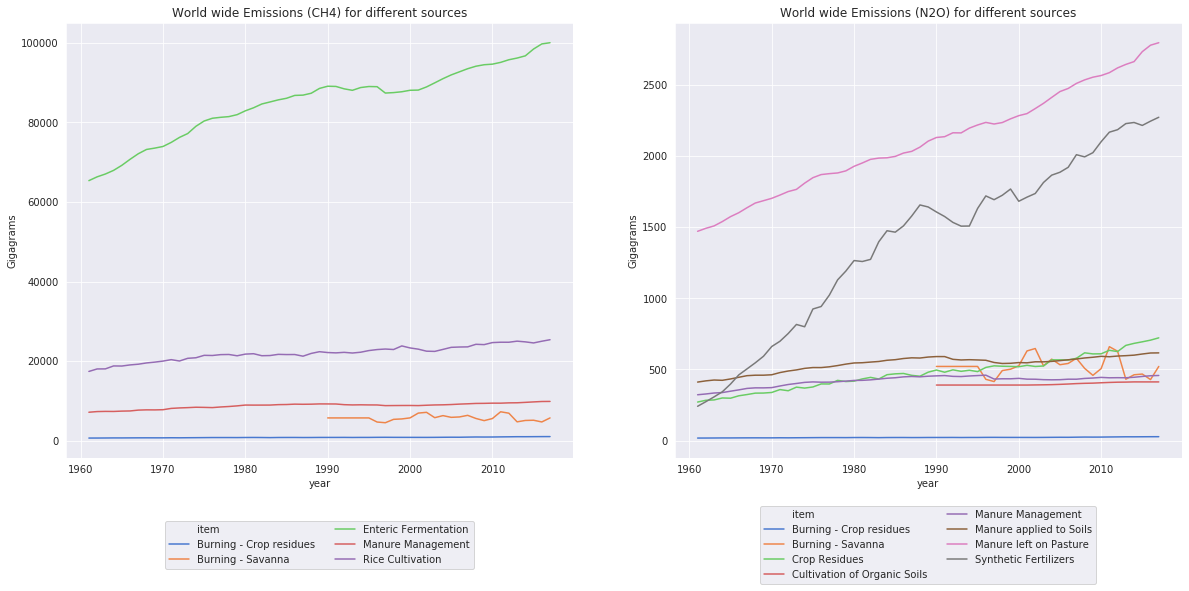

In [243]:
fig, axs = plt.subplots(figsize=(20, 8), ncols=2) 
for i, e in enumerate(emissions_agr_ch4_co2_world.elementcode.unique()):
    ax = axs[i]
    g = sns.lineplot(x='year', y='value', data=emissions_agr_ch4_co2_world[emissions_agr_ch4_co2_world.elementcode == e], hue='item', ax=ax)
    g.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=2);
    elem, unit = element_mapping[e]
    ax.set_title(f"World wide {elem} for different sources")
    ax.set_ylabel(f"{unit}");

#### Plot Analysis:
1. Emissions of CH4:
As seen previously, we knew that CH4 emissions are dominated by the Enteric Fermentation, and we can see that it has increased by roughly 50% since 1961. However other sources do not seem to have had the same increase in emissions.

2. Emissions of N2O:
Increases here are more interesting. We can see that emissions due to Synthetic fertilizers have increased linearly by almost 400%, with slightly lower steepness after ~1995. 
Manure Management's emissions also increased linearly.

---
### 4. Which countries contribute the most to emissions due to agriculture ?
---

We now have a global view on emissions worldwide, but it would be interesting to have a more detailed approach and see which countries countribute the most to the emissions of those 2 gases.

#### 1. Raw data
First we plot the total emissions in gigagrams for each country and gas (for CH4 and N2O) as a heatmap.

In [237]:
from plotting import merge_with_geopandas
emissions_agr_by_country = emissions_agriculture[emissions_agriculture.elementcode.isin([7225, 7230])].groupby(['areacode', 'area', 'elementcode', 'element', 'unit', 'year'])['value'].sum().reset_index()
emissions_agr_by_country = emissions_agr_by_country.merge(area_codes[['countrycode', 'iso3code']], left_on='areacode', right_on='countrycode').drop('countrycode', axis=1)



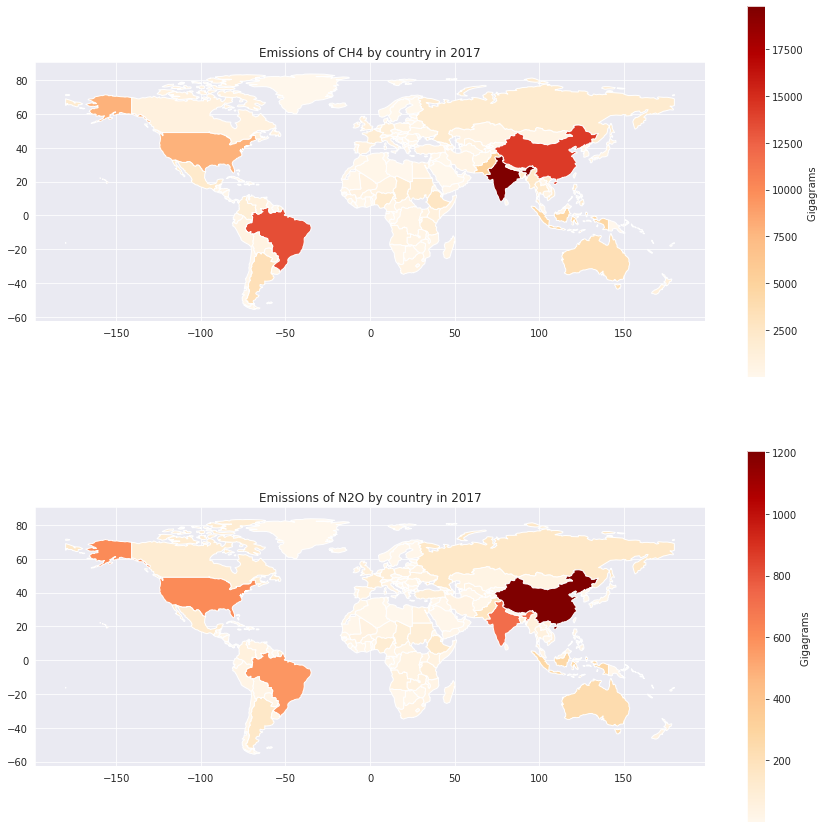

In [267]:
fig, ax = plt.subplots(figsize=(15, 15), nrows=2)
plot_map_ch4 = merge_with_geopandas(emissions_agr_by_country[emissions_agr_by_country.elementcode == 7225])
plot_map_n2o = merge_with_geopandas(emissions_agr_by_country[emissions_agr_by_country.elementcode == 7230])

plot_map_ch4[plot_map_ch4.year == 2017].plot(column='value', cmap="OrRd", ax=ax[0], legend=True, legend_kwds={'label': "Gigagrams ", 'orientation': "vertical"});
ax[0].set_title("Emissions of CH4 by country in 2017");

plot_map_n2o[plot_map_n2o.year == 2017].plot(column='value', cmap="OrRd", ax=ax[1], legend=True, legend_kwds={'label': "Gigagrams ", 'orientation': "vertical"});
ax[1].set_title("Emissions of N2O by country in 2017");

It looks like 4-5 countries contribute much more than others to emissions of the two gases: China, India, United States, Brazil and Australia. However, these countries' populations are quite signifcant. Let's look at the same graph, but after normalizing by population.

#### 2. Normalized by population


In [366]:
population_df = load_dataframe("data/population/Population_E_All_Data_(Normalized).csv", column_rename, duplicate_cols)
population_df = population_df[(population_df.elementcode == 511)][['areacode', 'year', 'value']]
population_df['value'] = population_df['value'] * 1000 # Unit is in 1000 persons, we want the real population
population_df = population_df.rename(columns={'value': 'population'})

In [381]:
from utils import normalize_by_pop

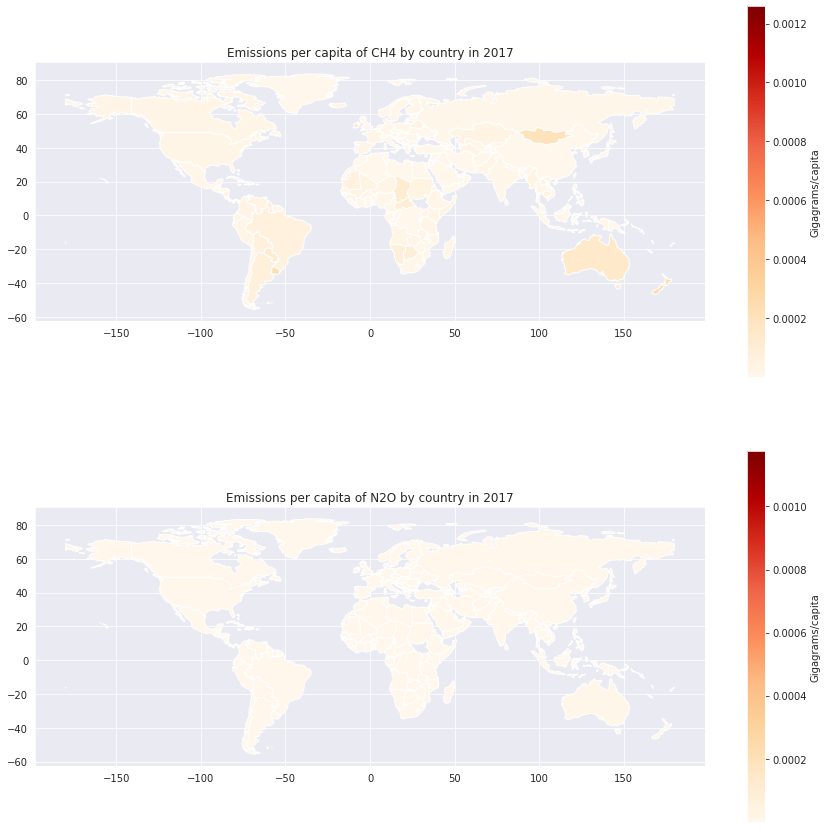

In [382]:
fig, ax = plt.subplots(figsize=(15, 15), nrows=2)
emissions_agr_by_country_with_pop = normalize_by_pop(emissions_agr_by_country, population_df)

plot_map_ch4 = merge_with_geopandas(emissions_agr_by_country_with_pop[emissions_agr_by_country_with_pop.elementcode == 7225])
plot_map_ch4 = plot_map_ch4[plot_map_ch4.year == 2017]
plot_map_n2o = merge_with_geopandas(emissions_agr_by_country_with_pop[emissions_agr_by_country_with_pop.elementcode == 7230])
plot_map_n2o = plot_map_n2o[plot_map_n2o.year == 2017]

plot_map_ch4.plot(column='value', cmap="OrRd", ax=ax[0], legend=True, legend_kwds={'label': "Gigagrams/capita", 'orientation': "vertical"});
ax[0].set_title("Emissions per capita of CH4 by country in 2017");

plot_map_n2o.plot(column='value', cmap="OrRd", ax=ax[1], legend=True, legend_kwds={'label': "Gigagrams/capita", 'orientation': "vertical"});
ax[1].set_title("Emissions per capita of N2O by country in 2017");

At a first glance, it seems that all countries have similar values of emission gigagrams/capita, but the scale tells us that some countries have higher values. Let's plot the distribution of values and check how it behaves.

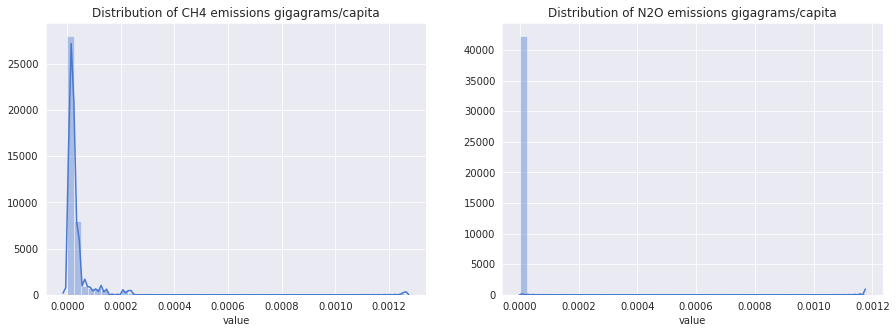

In [383]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
sns.distplot(plot_map_ch4['value'], ax=ax[0])
ax[0].set_title("Distribution of CH4 emissions gigagrams/capita")
sns.distplot(plot_map_n2o['value'], ax=ax[1])
ax[1].set_title("Distribution of N2O emissions gigagrams/capita");


The values seem to be very concentrated around 0, but both distributions have a very long tail. This could be due to a faulty value for one or a couple of countries.

After further inspection, we saw that one country seems to stand out and has a much higher value: Falkland Islands, a small group of islands in the southern Atlantic, with a population of around 3000 people. We believe this data is clearly wrong, as this country's agriculture is not an important economy. It either comes from mis-interpolated data by the FAO, or simply an outlier. For now, we will drop it and redo the plots to see how it looks.

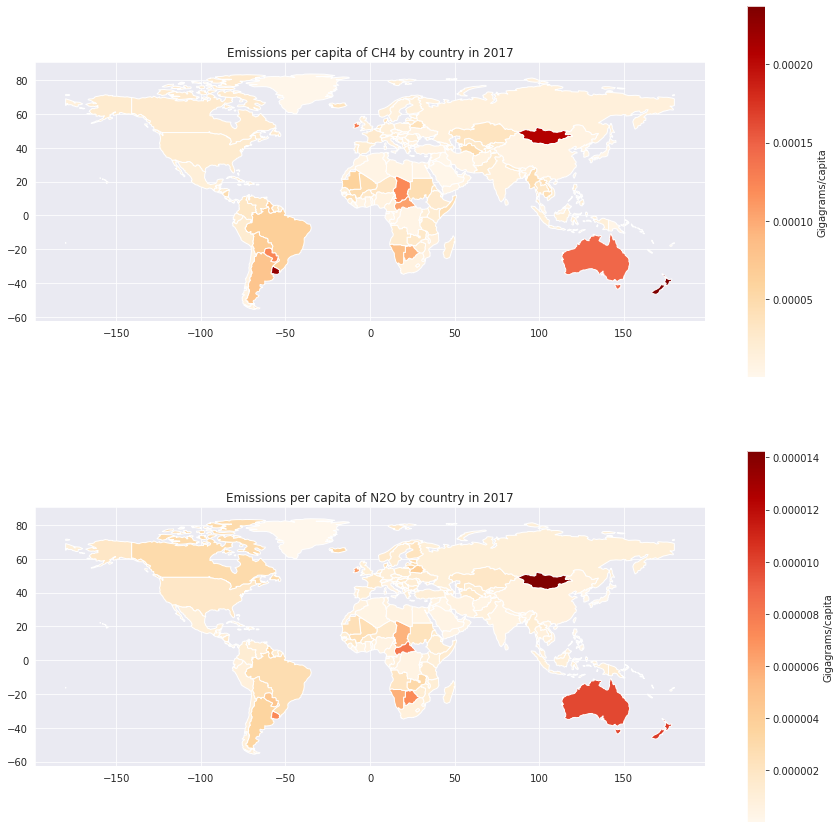

In [384]:
fig, ax = plt.subplots(figsize=(15, 15), nrows=2)
plot_map_ch4[plot_map_ch4.areacode != 65].plot(column='value', cmap="OrRd", ax=ax[0], legend=True, legend_kwds={'label': "Gigagrams/capita", 'orientation': "vertical"});
ax[0].set_title("Emissions per capita of CH4 by country in 2017");

plot_map_n2o[plot_map_n2o.areacode != 65].plot(column='value', cmap="OrRd", ax=ax[1], legend=True, legend_kwds={'label': "Gigagrams/capita", 'orientation': "vertical"});
ax[1].set_title("Emissions per capita of N2O by country in 2017");
plt.show()

The map looks much better now. We can see which countries stand out: Australia and Mongolia seem to have a very high emission factor per capita for both gases.

---
### 5. Which crops/livestock production has increased during that time frame ? And is the increase linear with the increase of population ?
---

We will now shift our focus to production of various crops and livestock. The data is separated in 3 categories: Livestock (live animals), Livestock produce (meat, eggs, etc..) and Crops.

#### 1. Evolution of Livestock stocks


In [385]:
production_livestock = load_dataframe("data_cleaned/production/Production_Livestock_All_data.csv").drop("unnamed:0", axis=1)
production_livestock_world = production_livestock[production_livestock.areacode.isin(world_countries)]\
                                .groupby(['elementcode', 'element', 'unit', 'itemcode', 'item', 'year'])['value'].sum().reset_index()
production_livestock_world = production_livestock_world[production_livestock_world.itemcode != 1756]

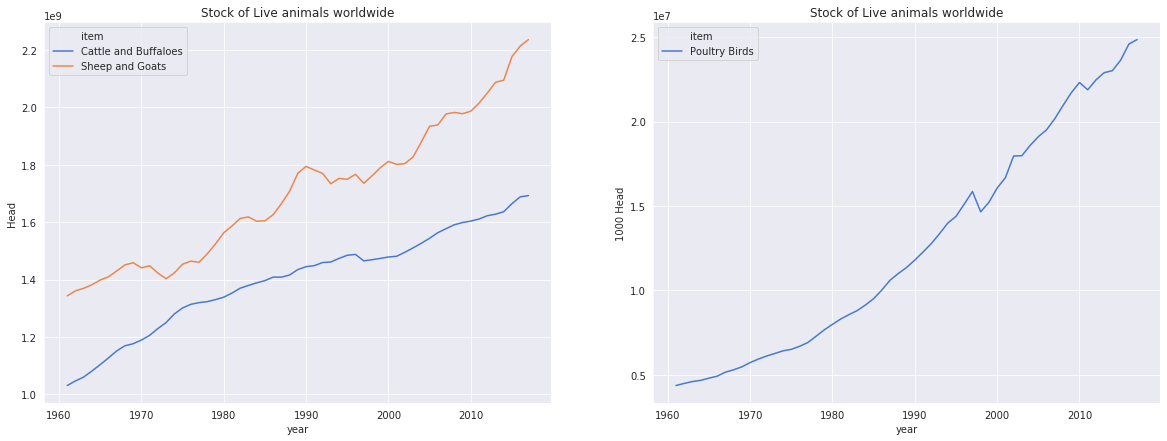

In [386]:
fig, ax = plt.subplots(figsize=(20, 7), ncols = production_livestock_world.elementcode.nunique())
for i, e in enumerate(production_livestock_world.elementcode.unique()):
    df = production_livestock_world[production_livestock_world.elementcode == e]
    sns.lineplot(x='year', y='value', data=df, hue='item', ax=ax[i])
    ax[i].set_title("Stock of Live animals worldwide")
    ax[i].set_ylabel(element_mapping[e][1])

As expected, of course, all stocks of live animals have increased. These take into consideration all animals used to produce food: it can be dairy cattle, layer chicken etc.. 

Now we normalize by population to see if the increase is proportional to the increase in population

In [387]:
production_livestock_world['areacode'] = 5000
production_livestock_world_norm = normalize_by_pop(production_livestock_world, population_df)

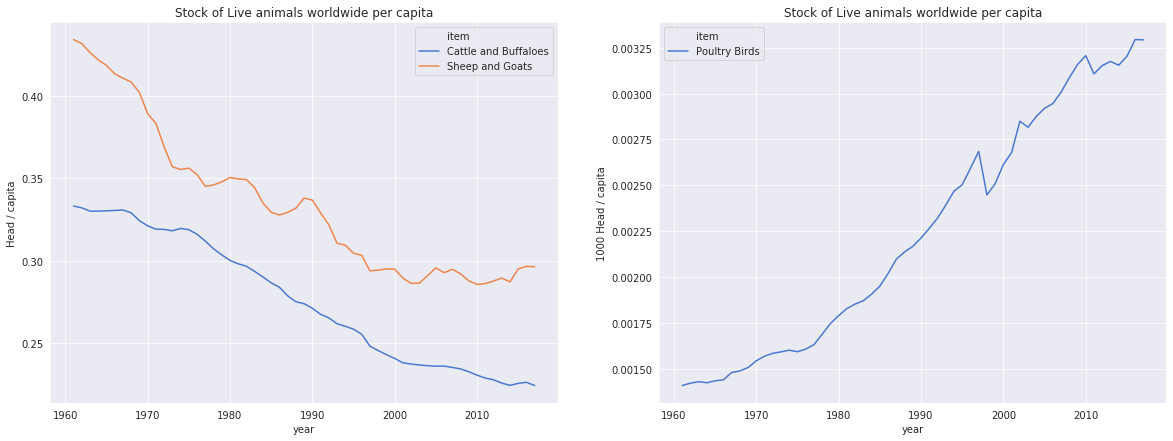

In [389]:
fig, ax = plt.subplots(figsize=(20, 7), ncols = production_livestock_world_norm.elementcode.nunique())
for i, e in enumerate(production_livestock_world_norm.elementcode.unique()):
    df = production_livestock_world_norm[production_livestock_world_norm.elementcode == e]
    sns.lineplot(x='year', y='value', data=df, hue='item', ax=ax[i])
    ax[i].set_title("Stock of Live animals worldwide per capita")
    ax[i].set_ylabel(f"{element_mapping[e][1]} / capita")

Surprisingly, the amount of "Sheep and Goats" and "Cattle and Buffaloes" per capita seems to be decreasing, while for Poultry birds it is clearly increasing. 
This could be due to multiple factors:
- Cattle, Sheep and Goats need more time to grow, enducing a higher cost in production
- Poultry Birds are cheaper to feed, need less space to grow, and we have developped techniques where they can be stacked by millions easily, which is not the case for bigger animals.
- The increase in population was more dominant in countries where Red meat consumption is lower (India).
- People prefer to eat chicken today rather than in the 60s

#### 2. Evolution of production of Livestock products

In [396]:
production_livestock_prim = load_dataframe("data_cleaned/production/Production_Livestock_Primary_All_data.csv")
production_livestock_prim = production_livestock_prim[production_livestock_prim.areacode.isin(world_countries)]\
                                .groupby(['elementcode', 'element', 'unit', 'itemcode', 'item', 'year'])['value'].sum().reset_index()
production_livestock_prim = production_livestock_prim[(~production_livestock_prim.itemcode.isin([1765])) & (production_livestock_prim.elementcode == 5510)]

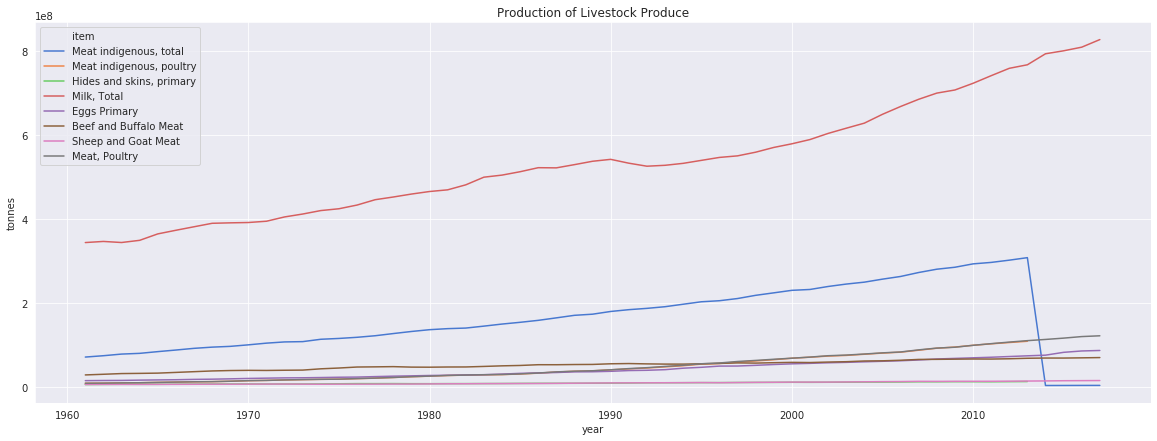

In [401]:
fig, ax = plt.subplots(figsize=(20, 7), ncols = production_livestock_prim.elementcode.nunique())
for i, e in enumerate(production_livestock_prim.elementcode.unique()):
    df = production_livestock_prim[production_livestock_prim.elementcode == e]
    sns.lineplot(x='year', y='value', data=df, hue='item', ax=ax)
    ax.set_title("Production of Livestock Produce")
    ax.set_ylabel(element_mapping[e][1])

In [402]:
production_livestock_prim['areacode'] = 5000
production_livestock_prim = normalize_by_pop(production_livestock_prim, population_df)

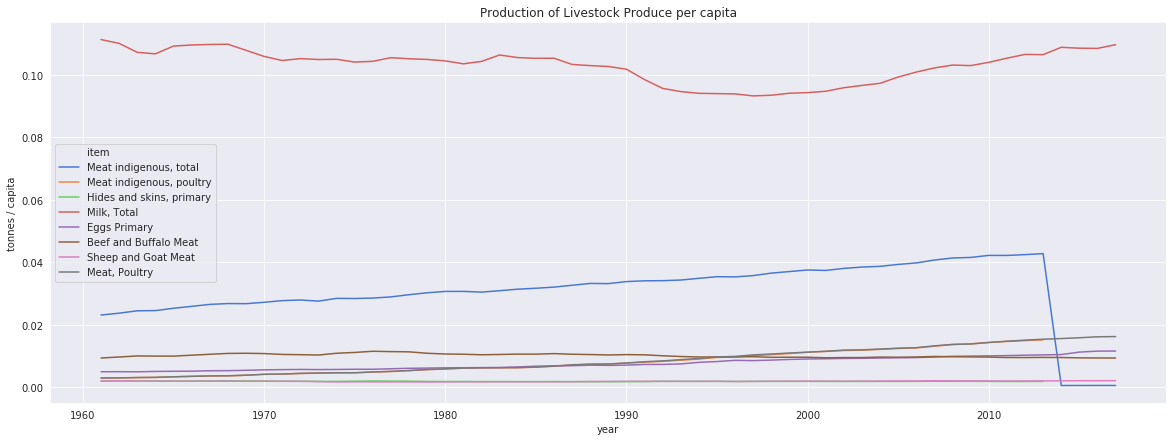

In [407]:
fig, ax = plt.subplots(figsize=(20, 7), ncols = production_livestock_prim.elementcode.nunique())
for i, e in enumerate(production_livestock_prim.elementcode.unique()):
    df = production_livestock_prim[production_livestock_prim.elementcode == e]
    sns.lineplot(x='year', y='value', data=df, hue='item', ax=ax)
    ax.set_title("Production of Livestock Produce per capita")
    ax.set_ylabel(f"{element_mapping[e][1]} / capita")

#### 3. Evolution of production of crops

In [418]:
production_crops = load_dataframe("data_cleaned/production/Production_Crops_All_data.csv")
production_crops = production_crops[production_crops.areacode.isin(world_countries)]\
                                .groupby(['elementcode', 'element', 'unit', 'itemcode', 'item', 'year'])['value'].sum().reset_index()
production_crops = production_crops[(~production_crops.itemcode.isin([1717, 1714]))&(production_crops.elementcode == 5510)]

In [419]:
production_crops[['itemcode','item' ]].drop_duplicates()

,itemcode,item
855,1720,"Roots and Tubers, Total"
912,1726,"Pulses, Total"
969,1729,"Treenuts, Total"
1026,1732,"Oilcrops, Oil Equivalent"
1083,1735,Vegetables Primary
1140,1738,Fruit Primary
1197,1753,Fibre Crops Primary
1254,1804,"Citrus Fruit, Total"
1311,1814,"Coarse Grain, Total"
1368,1817,Cereals (Rice Milled Eqv)


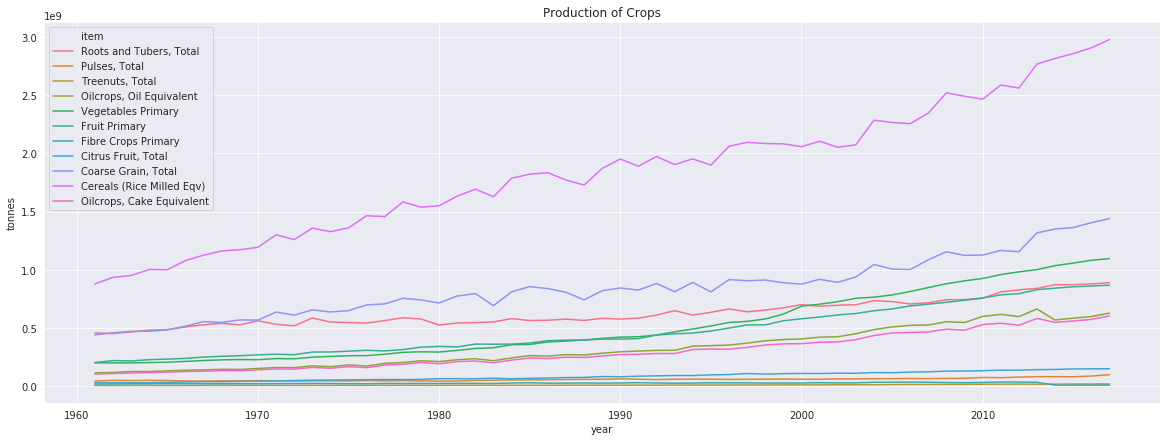

In [420]:
fig, ax = plt.subplots(figsize=(20, 7), ncols = production_crops.elementcode.nunique())
for i, e in enumerate(production_crops.elementcode.unique()):
    df = production_crops[production_crops.elementcode == e]
    sns.lineplot(x='year', y='value', data=df, hue='item', ax=ax)
    ax.set_title("Production of Crops")
    ax.set_ylabel(element_mapping[e][1])